In [1]:
import lib
from MHNeuralState import MHNeuralState
import qutip as qt
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn

In [2]:
h = lib.TFIM_hamiltonian(10, 1, 1)

In [3]:
h

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(1024, 1024), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-10.  -1.  -1. ...   0.   0.   0.]
 [ -1.  -6.   0. ...   0.   0.   0.]
 [ -1.   0.  -6. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  -6.   0.  -1.]
 [  0.   0.   0. ...   0.  -6.  -1.]
 [  0.   0.   0. ...  -1.  -1. -10.]]

In [4]:
h.__reduce__()

(<function copyreg._reconstructor(cls, base, state)>,
 (qutip.core.qobj.Qobj, object, None),
 {'_isherm': True,
  '_isunitary': None,
  '_data': CSR(shape=(1024, 1024), nnz=11264),
  '_dims': Dimensions(Compound(Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2)), Compound(Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2))),
  'qutip_version': '5.0.4'})

In [5]:
vec = qt.tensor([qt.basis(2, 0)] * 10)
vec.__reduce__()

(<function copyreg._reconstructor(cls, base, state)>,
 (qutip.core.qobj.Qobj, object, None),
 {'_isherm': None,
  '_isunitary': None,
  '_data': Dense(shape=(1024, 1), fortran=True),
  '_dims': Dimensions(Compound(Field(), Field(), Field(), Field(), Field(), Field(), Field(), Field(), Field(), Field()), Compound(Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2))),
  'qutip_version': '5.0.4'})

In [6]:
# vec.dtype = qt.data.CSR

In [7]:
def f(x):
    return np.exp(-x ** 2) * (2 + np.sin(5*x)+np.sin(2*x))

In [8]:
def MH_continuous(p, x_func, x0, num_samples, burnin = 0, lag = 0):
    x = x0
    data = [x] 
    for _ in range(burnin):
        new_x = x_func(x)
        ratio = p(new_x) / p(x)
        if ratio > 1 or ratio > npr.uniform(0, 1):
            x = new_x
    for _ in range(num_samples):
        for _ in range(lag):
            new_x = x_func(x)
            ratio = p(new_x) / p(x)
            if ratio > 1 or ratio > npr.uniform(0, 1):
                x = new_x
        new_x = x_func(x)
        ratio = p(new_x) / p(x)
        if ratio > 1 or ratio > npr.uniform(0, 1):
            data.append(new_x)
            x = new_x 
        else: 
            data.append(x)
    return data

In [9]:
samples = 10000
data = MH_continuous(f, lambda x : npr.normal(x, 1), 0, samples, burnin = 50, lag = 0)

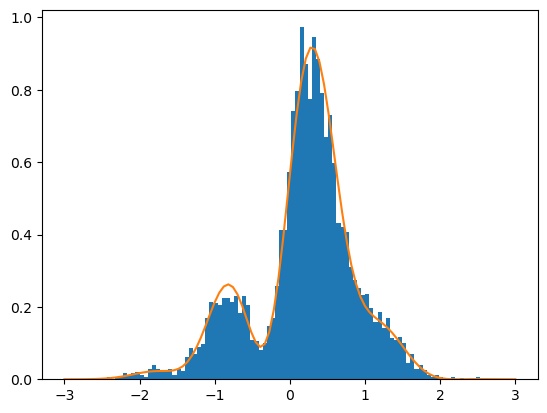

In [10]:
hist = plt.hist(data, density = True, bins = 100)
# for i in range(len(hist[0])):
#     hist[0][i] = hist[0][i] / samples
# # plt.clf()
# hist
x = np.linspace(-3, 3, 100)
norm = np.trapezoid(x, f(x))
plt.plot(x, - f(x) / norm)
plt.show()

In [11]:
from scipy.special import factorial
def poisson(k, lmd):
    return np.exp(-lmd) * lmd ** k / factorial(k)

In [12]:
def sample_x(x, sigma, bounds = (float('-inf'), float('inf'))):
    new_x = round(npr.normal(x, sigma)) % (bounds[1] + 1)
    # new_x = (x + [-1, 1][npr.randint(0, 2)]) % (bounds[1] + 1)
    # print(new_x)
    return new_x

In [13]:
samples = 10000
lmd = 5
data = MH_continuous(lambda x : poisson(x, lmd), 
                     lambda x : sample_x(x, 2, (0, float('inf'))), 
                     5, samples)

C:\Users\taoha\AppData\Local\Temp\ipykernel_33140\1483049671.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(-lmd) * lmd ** k / factorial(k)


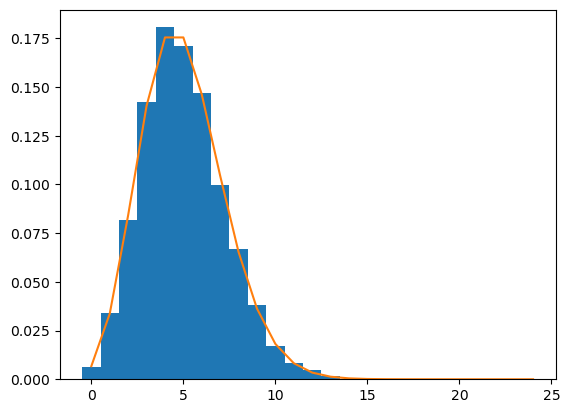

In [14]:
hist = plt.hist(data, density = True, bins = [-0.5 + n for n in range(0, 20)])
x = np.array([n for n in range(0, 25)])
y = poisson(x, lmd)
norm = np.trapezoid(x, y)
plt.plot(x, y)
plt.show()

In [15]:
N = 3

In [16]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

In [17]:
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])

In [18]:
input = lib.generate_input_torch(N)
model_state = lib.model_to_ground_state(model, input, amp_phase)

In [19]:
model_state

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[-0.35194483-0.00858188j]
 [-0.34995145+0.00958011j]
 [-0.3497386 -0.01166087j]
 [-0.34829739+0.00543425j]
 [-0.35802883-0.02541118j]
 [-0.3566682 -0.00657493j]
 [-0.35589117-0.0274364j ]
 [-0.35513374-0.00962866j]]

In [20]:
np.abs(np.squeeze(model_state.full())) ** 2

array([0.12393881, 0.12255779, 0.12245306, 0.1213406 , 0.12883037,
       0.12725544, 0.12741128, 0.12621269])

In [21]:
model_state.dag() @ model_state

(1.0000000454876254+0j)

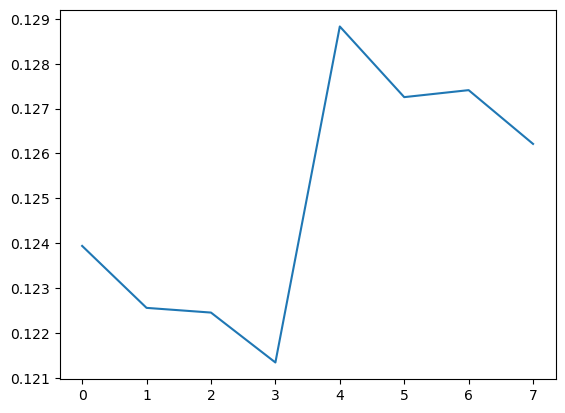

In [22]:
plt.plot([n for n in range(0, 2 ** N)], np.abs(np.squeeze(model_state.full())) ** 2)
plt.show()

In [23]:
model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : sample_x(x, 20, (0, 2 ** N - 1)), 5, 10000, lag = 0)

c:\Users\taoha\OneDrive\Documents\GitHub\kans-urop\MHNeuralState.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  tens = torch.tensor([lib.generate_state_1D(x, N)], dtype = torch.float32)


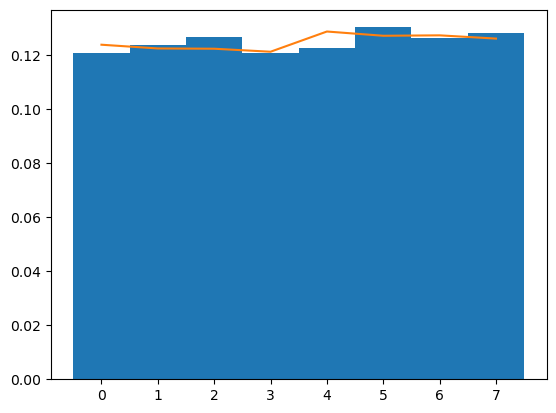

In [24]:
hist = plt.hist(model_MH.distribution_to_list(), density = True, bins = [-0.5 + n for n in range(0, 2 ** N + 1)])
plt.plot([n for n in range(0, 2 ** N)], np.abs(np.squeeze(model_state.full())) ** 2)
plt.show()

In [25]:
from MHNeuralState import SparseStateVector

In [26]:
SparseStateVector.inner_product(model_MH, model_MH)

tensor(3.0032+0.j, grad_fn=<AddBackward0>)

In [27]:
J = 1
Gamma = 1

In [28]:
lib.TFIM_expectation_from_torch(model(input), (N, J, Gamma), amp_phase)

tensor(-5.1956, grad_fn=<DivBackward0>)

In [30]:
SparseStateVector.TFIM_expectation_from_sparse(model_MH, N, J, Gamma) / (SparseStateVector.inner_product(model_MH, model_MH)) ** 0.5

tensor(-5.1956+0.j, grad_fn=<DivBackward0>)